In [44]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))
  
# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/digit-recognizer/sample_submission.csv
/kaggle/input/digit-recognizer/train.csv
/kaggle/input/digit-recognizer/test.csv


In [45]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
%matplotlib inline

In [46]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
import torchvision
from torchvision.transforms import ToTensor
import torchvision.transforms as transforms
from torchvision.utils import make_grid



#### Class Definition (class MNIST(Dataset):):

- We're defining a new class named MNIST that inherits from Dataset. This class       will be used to handle your MNIST dataset.

#### Constructor (def __init__(self, X, y=None, transform=None):):

- The __init__ method is the class constructor. It initializes the object when you     create an instance of the class.
- **'self.X':** It stores the input data (features), which is expected to be a         DataFrame with image pixel values.
- **'self.y':** It stores the labels corresponding to the images. It is optional and   can be set to None if labels are not provided.
- **'self.transform':** It stores an optional data transformation function that can     be applied to the images.

#### Length Method (def __len__(self):):

- The __len__ method returns the length of the dataset, which is the number of         samples (rows) in your input data X.

#### Get Item Method (def __getitem__(self, index):):

- The __getitem__ method is used to get a specific item from the dataset given an     index.
- image = self.X.iloc[index, ].values.astype(np.uint8).reshape((28, 28, 1)): It       extracts the image at the specified index, converts it to a NumPy array of type     uint8, and reshapes it into a 28x28x1 image. This assumes the input data is         organized in a DataFrame with pixel values.
- if self.transform is not None: image = self.transform(image): If a transformation   function is provided, it applies that transformation to the image.
- if self.y is not None: return image, self.y.iloc[index]: If labels are provided     (y is not None), it returns both the transformed image and the corresponding         label. Otherwise, it returns just the transformed image.




In summary, this class (MNIST) is designed to handle the MNIST dataset. It takes in features (X) and labels (y), and it allows for an optional data transformation (transform). The __len__ method gives the total number of samples, and the __getitem__ method provides a way to retrieve a specific image and its label from the dataset. This class structure is in line with PyTorch's Dataset class, making it suitable for use with PyTorch's DataLoader.

In [47]:
class MNIST(Dataset):
    def __init__(self, X, y=None, transform=None):
        self.X = X
        self.y = y
        self.transform = transform

    def __len__(self):
        return len(self.X.index)

    def __getitem__(self, index):
        image = self.X.iloc[index, ].values.astype(np.uint8).reshape((28, 28, 1))

        if self.transform is not None:
            image = self.transform(image)

        if self.y is not None:
            return image, self.y.iloc[index]
        else:
            return image

In [48]:
train_df = pd.read_csv("/kaggle/input/digit-recognizer/train.csv")
train_df.head()

,label,pixel0,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,...,pixel774,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783
0,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,4,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [49]:
test_df = pd.read_csv("/kaggle/input/digit-recognizer/test.csv")
test_df.head()

,pixel0,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,pixel9,...,pixel774,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [50]:
print('Train data shape :',train_df.shape)
print('Test data shape :',test_df.shape)

Train data shape : (42000, 785)
Test data shape : (28000, 784)


In [51]:
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cuda'

#### Train-Test Split:

- The __train_test_split__ function from scikit-learn is used to split the training   data (train_df.iloc[:, 1:]) into training __(X_train, y_train)__ and validation     __(X_valid, y_valid)__ sets.
- The __test_size=1/6__ parameter specifies that 1/6 (approximately 16.67%) of the     data should be used for validation.
- The __random_state=42__ parameter ensures reproducibility by fixing the random seed.

In [52]:
# Splitting the training data into training and validation sets
X_train, X_valid, y_train, y_valid = \
    train_test_split(train_df.iloc[:, 1:], train_df['label'], test_size=1/6, random_state=42)

# Assigning the test data to X_test
X_test = test_df

# Printing the shapes of the datasets
print('train image shape : ', X_train.shape)
print('train label shape : ', y_train.shape)
print('valid image shape : ', X_valid.shape)
print('valid label image : ', y_valid.shape)
print('test image shape  : ', X_test.shape)

train image shape :  (35000, 784)
train label shape :  (35000,)
valid image shape :  (7000, 784)
valid label image :  (7000,)
test image shape  :  (28000, 784)


Next code is preparing and loading datasets for training, validation, and testing using PyTorch's **Dataset** and **DataLoader** classes

**1. Data Transformation:**

- __'transforms.Compose'__ allows you to chain together multiple image transformations.
- __'transforms.ToPILImage()'__ converts the input image to a PIL Image. This is often required before applying certain transformations.
- __'transforms.RandomRotation(10)'__ applies a random rotation to the image, up to a maximum angle of 10 degrees.
- __'transforms.ToTensor()'__ converts the image to a PyTorch tensor.

**2. Creating Datasets:**

- __'train_dataset'__ is created using the training data (X_train and y_train) and the specified transformation (transform).
- __'valid_dataset'__ is created using the validation data (X_valid and y_valid) and only the ToTensor transformation.
- __'test_dataset'__ is created using the test data (X_test) and only the ToTensor transformation.

**3. Creating Data Loaders:**

- __'DataLoader'__ is used to create iterators that provide batches of data during training, validation, and testing.
- __'batch_size=128'__ specifies that each batch will contain 128 samples.
- __'shuffle=True'__ for the training loader means that the data will be shuffled before each epoch to introduce randomness and prevent the model from memorizing the order of the training data.
- __'shuffle=False'__ for the validation and test loaders means that the data will not be shuffled during evaluation.



In summary, this code sets up data transformations, creates PyTorch datasets with those transformations, and then creates data loaders to efficiently iterate through batches of the datasets during training, validation, and testing. The transformations are applied to augment the training data by introducing random rotations.

In [53]:
transform=transforms.Compose([
    transforms.ToPILImage(), # PIL stands for the Python Imaging Library, and it is a library for opening, manipulating, and saving many different image file formats.
    transforms.RandomRotation(10),
    transforms.ToTensor()
])

train_dataset = MNIST(X=X_train, y=y_train, transform=transform)
valid_dataset = MNIST(X=X_valid, y=y_valid, transform=transforms.ToTensor())
test_dataset = MNIST(X=X_test, transform=transforms.ToTensor())

train_loader = DataLoader(dataset=train_dataset, batch_size=128, shuffle=True)
valid_loader = DataLoader(dataset=valid_dataset, batch_size=128, shuffle=False)
test_loader = DataLoader(dataset=test_dataset, batch_size=128, shuffle=False)

**1. Iterator Creation:**

- __'train_loader'__ is a PyTorch __'DataLoader'__ that you created earlier. It provides batches of data during training.
- __'iter(train_loader)'__ creates an iterator from the data loader, allowing you to easily get batches of data one at a time.

**2. Getting a Batch:**
- __'next(dataiter)'__ retrieves the next batch of data from the iterator. In this case, it gets the images and labels for one batch.
- __'images'__ is a batch of images, and __'labels'__ is a batch of corresponding labels.

In [54]:
dataiter = iter(train_loader)
images, labels = next(dataiter)

print('images shape on PyTroch : ', images.size())
print('labels shape on PyTroch : ', labels.size())

images shape on PyTroch :  torch.Size([128, 1, 28, 28])
labels shape on PyTroch :  torch.Size([128])



Next code is using the __'make_grid'__ function from the __'torchvision.utils'__ module to create a grid of images. The resulting grid is then displayed using Matplotlib. Let's break down the code:

**1. Creating the Image Grid:**

- __'images[:25]'__ selects the first 25 images from the batch. The images variable contains a batch of images obtained from the DataLoader.
- __'make_grid'__ arranges these images into a grid. The nrow=5 parameter specifies that there should be 5 images in each row of the grid.

**2. Creating a Matplotlib Figure:**

- __'plt.subplots'__ is a Matplotlib function that creates a figure and a set of subplots.
- __'fig'__ is the entire figure, and __'ax'__ is a subplot (or an array of subplots).

**3. Displaying the Image Grid:**

- __'ax.imshow'__ displays an image on the subplot (ax).
- __'grid.numpy()'__ converts the PyTorch tensor grid to a NumPy array.
- __'transpose((1, 2, 0))'__ rearranges the dimensions of the array. This is often required because Matplotlib expects the last dimension to represent color channels (if any), and PyTorch stores channels as the first dimension.

**4. Turning Off Axis Labels:**

- __'ax.axis('off')'__ removes the axis labels and ticks, providing a cleaner visualization.

In simpler terms, this code takes a batch of images, selects the first 25, arranges them into a 5x5 grid, and then displays the grid using Matplotlib. The resulting figure shows a compact view of multiple images for quick visual inspection.

(-0.5, 151.5, 151.5, -0.5)

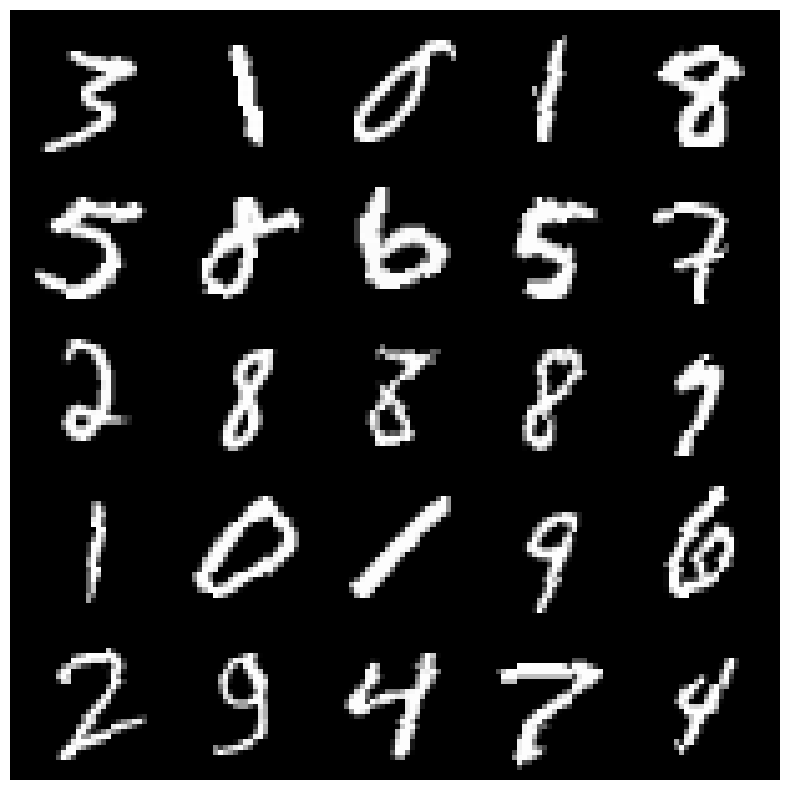

In [55]:
grid = make_grid(images[:25], nrow=5)

fig, ax = plt.subplots(figsize=(15, 10))
ax.imshow(grid.numpy().transpose((1, 2, 0)))
ax.axis('off')

This code defines a simple Multi-Layer Perceptron (MLP) neural network using PyTorch's __'nn.Module class'__.

**1. Class Definition:**

- This creates a new class named __'MLP'__ that inherits from PyTorch's __'nn.Module'__. This means it's a PyTorch model.

**2. Constructor (__init__ method):**

- __init__ is a special method that initializes the object when an instance of the class is created.
- __super(MLP, self).__init__() calls the constructor of the parent class (nn.Module).
- __'self.layers'__ defines the layers of the neural network using nn.Sequential. It consists of:
  - A fully connected (linear) layer with 784 input features and 100 output features.
  - A Rectified Linear Unit (ReLU) activation function.
  - Another fully connected layer with 100 input features and 10 output features.
  
**3. Forward Method (forward method):**

- The __'forward'__ method defines the forward pass of the neural network.
- __'x'__ is the input tensor (typically a batch of images).
- __'x.view(x.size(0), -1)'__ reshapes the input tensor to flatten it. For example, it transforms a tensor of shape (128, 1, 28, 28) to (128, 1 x 28 x 28).
- __'self.layers(x)'__ passes the flattened input through the defined layers (self.layers).
- The result is returned as the output of the forward pass.

In simpler terms, this MLP model takes an input tensor representing images (flattening them if needed), passes them through two fully connected layers with ReLU activation in between, and produces an output tensor. This type of model is commonly used for classification tasks.

In [56]:
class MLP(nn.Module):
    def __init__(self):
        super(MLP, self).__init__()
        self.layers = nn.Sequential(
            nn.Linear(784, 100),
            nn.ReLU(),
            nn.Linear(100, 10)
        )

    def forward(self, x):
        # convert tensor (128, 1, 28, 28) --> (128, 1*28*28)
        x = x.view(x.size(0), -1)
        x = self.layers(x)
        return x

The provided code is creating an instance of a Multi-Layer Perceptron (MLP) model using PyTorch and then printing the model.

**1. Creating an MLP Model Instance:**

- his line creates a new instance of the __'MLP'__ class, which is a neural network model defined using PyTorch.
- The __'MLP'__ class, as previously defined, consists of two fully connected layers with a Rectified Linear Unit (ReLU) activation function in between.

**2. Printing the Model:**

- This line prints information about the model.
- When you print a PyTorch model instance, it shows the architecture of the model, including the layers and their configurations.

In simpler terms, the code creates a neural network model (MLP) and then prints its architecture, showing the layers and their configurations. This information is helpful for understanding the structure of the model you've just created.

In [57]:
model = MLP().to(device)
print(model)

MLP(
  (layers): Sequential(
    (0): Linear(in_features=784, out_features=100, bias=True)
    (1): ReLU()
    (2): Linear(in_features=100, out_features=10, bias=True)
  )
)


Next code is setting up an optimizer and a loss function for training a neural network model.

**1. Optimizer:**

- **Explanation:** An optimizer is a tool that helps the model update its parameters during training to improve its performance on the task.
- __torch.optim.Adam:__ This line is using the Adam optimizer, a popular optimization algorithm.
- __model.parameters():__ It tells the optimizer which parameters of the model should be updated during training. In this case, it includes the weights and biases of the MLP model.
- __lr=0.001:__ It sets the learning rate, which controls the step size of the parameter updates. A smaller learning rate makes the updates smaller and vice versa.

**2. Loss Function:**

- **Explanation:** The loss function measures how well the model is performing by comparing its predictions to the actual target values.
- __nn.CrossEntropyLoss():__ This line is using the Cross Entropy Loss, which is commonly used for classification tasks.
- For classification problems (like recognizing digits), Cross Entropy Loss is suitable as it penalizes the model more when it makes confident incorrect predictions.

In simpler terms, the optimizer guides the model to adjust its parameters during training, and the loss function calculates how well the model is doing. The goal during training is to minimize this loss, improving the model's ability to make accurate predictions. The Adam optimizer is a method for making these adjustments, and Cross Entropy Loss is a measure of how far off the model's predictions are from the actual labels.

In [58]:
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
loss_fn = nn.CrossEntropyLoss()

Next code is training a neural network model for a specified number of epochs (iterations over the entire dataset) and printing the training progress.

In [59]:
mean_train_losses = []
mean_valid_losses = []
valid_acc_list = []
epochs = 15

for epoch in range(epochs):
    model.train()

    train_losses = []
    valid_losses = []
    for i, (images, labels) in enumerate(train_loader):
        images, labels = images.to(device), labels.to(device)

        optimizer.zero_grad()

        outputs = model(images)
        loss = loss_fn(outputs, labels)
        loss.backward()
        optimizer.step()

        train_losses.append(loss.item())

        if (i * 128) % (128 * 100) == 0:
            print(f'{i * 128} / 50000')

    model.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for i, (images, labels) in enumerate(valid_loader):
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            loss = loss_fn(outputs, labels)

            valid_losses.append(loss.item())

            _, predicted = torch.max(outputs.data, 1)
            correct += (predicted == labels).sum().item()
            total += labels.size(0)

    mean_train_losses.append(np.mean(train_losses))
    mean_valid_losses.append(np.mean(valid_losses))

    accuracy = 100*correct/total
    valid_acc_list.append(accuracy)
    print('epoch : {}, train loss : {:.4f}, valid loss : {:.4f}, valid acc : {:.2f}%'\
         .format(epoch+1, np.mean(train_losses), np.mean(valid_losses), accuracy))

0 / 50000
12800 / 50000
25600 / 50000
epoch : 1, train loss : 0.5773, valid loss : 0.2988, valid acc : 91.43%
0 / 50000
12800 / 50000
25600 / 50000
epoch : 2, train loss : 0.2799, valid loss : 0.2370, valid acc : 93.09%
0 / 50000
12800 / 50000
25600 / 50000
epoch : 3, train loss : 0.2247, valid loss : 0.1922, valid acc : 94.31%
0 / 50000
12800 / 50000
25600 / 50000
epoch : 4, train loss : 0.1867, valid loss : 0.1650, valid acc : 95.34%
0 / 50000
12800 / 50000
25600 / 50000
epoch : 5, train loss : 0.1585, valid loss : 0.1504, valid acc : 95.76%
0 / 50000
12800 / 50000
25600 / 50000
epoch : 6, train loss : 0.1377, valid loss : 0.1347, valid acc : 96.09%
0 / 50000
12800 / 50000
25600 / 50000
epoch : 7, train loss : 0.1205, valid loss : 0.1234, valid acc : 96.36%
0 / 50000
12800 / 50000
25600 / 50000
epoch : 8, train loss : 0.1123, valid loss : 0.1194, valid acc : 96.44%
0 / 50000
12800 / 50000
25600 / 50000
epoch : 9, train loss : 0.1036, valid loss : 0.1116, valid acc : 96.71%
0 / 50000


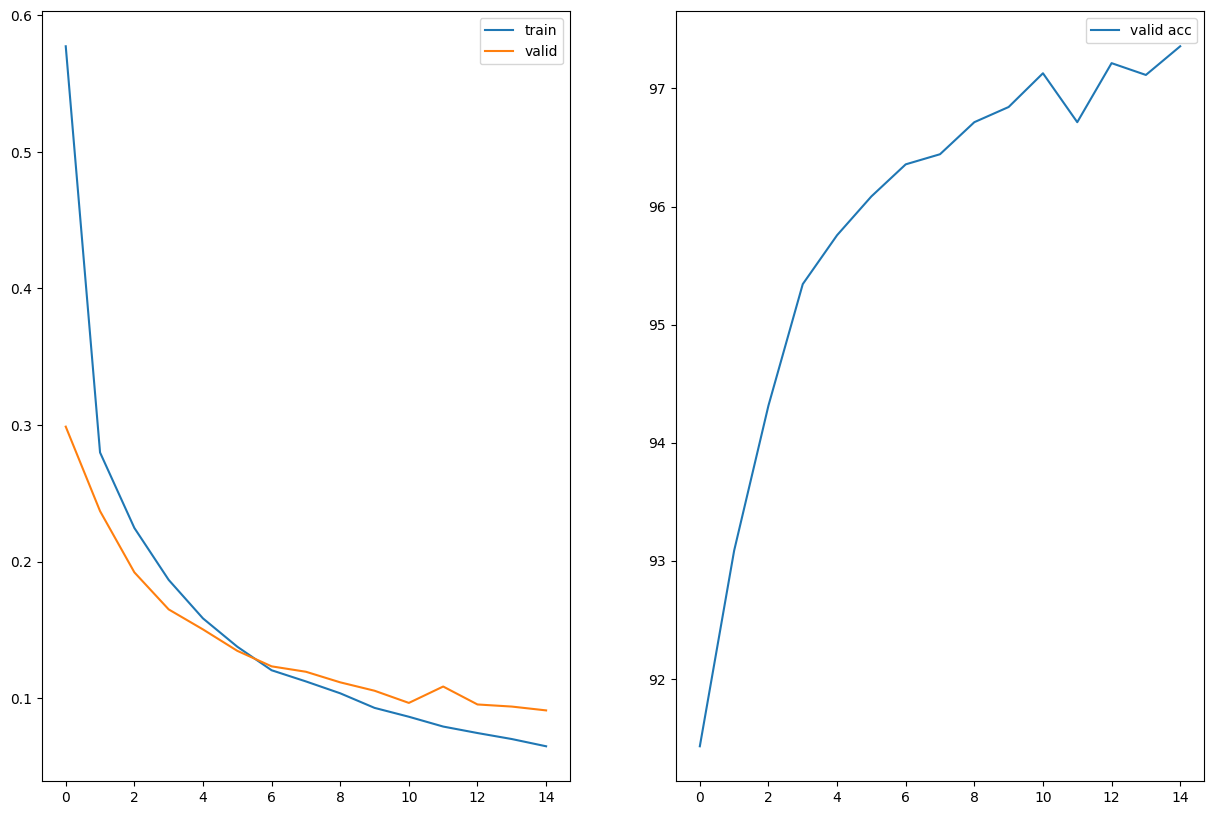

In [60]:
fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(15, 10))
ax1.plot(mean_train_losses, label='train')
ax1.plot(mean_valid_losses, label='valid')
lines, labels = ax1.get_legend_handles_labels()
ax1.legend(lines, labels, loc='best')

ax2.plot(valid_acc_list, label='valid acc')
ax2.legend()

This code is creating a visual representation of training and validation metrics over epochs. The left subplot (__'ax1'__) displays training and validation losses, and the right subplot (__'ax2'__) displays validation accuracy. The legend in each subplot helps identify which line corresponds to which metric. The figure is displayed with two side-by-side plots.

Next code is using a trained neural network model to make predictions on a test dataset. Let's break it down in simpler terms:


- __'model.eval()'__ sets the model into evaluation mode. In evaluation mode, the model does not update its parameters, and certain layers (like dropout) behave differently. It's a precautionary step when making predictions.

- __'test_preds'__ is an empty tensor that will be used to store the model's predictions on the test dataset.

- __'for i, images in enumerate(test_loader):'__ iterates through batches of images in the test dataset.

- __'outputs = model(images)'__ computes predictions for the batch of images using the trained model.

- __'pred = outputs.max(1, keepdim=True)[1]'__ extracts the index of the maximum predicted value for each image. This represents the predicted class.

- __'test_preds = torch.cat((test_preds, pred), dim=0)'__ concatenates the predictions for the current batch to the test_preds tensor. This builds a tensor containing predictions for the entire test dataset.

In simple terms, the code prepares the model for making predictions, iterates through batches of test images, and stores the model's predictions in the test_preds tensor. After running this code, test_preds will contain the predicted class labels for each image in the test dataset.

In [61]:
model.eval()
test_preds = torch.LongTensor()

for i, images in enumerate(test_loader):
    images = images.to(device)
    outputs = model(images)

    pred = outputs.max(1, keepdim=True)[1]
    test_preds = torch.cat((test_preds.to(device), pred.to(device)), dim=0)

Next code is creating a DataFrame (out_df) to organize the predictions made by the model on a test dataset. Let's break it down in simpler terms:


- __'out_df = pd.DataFrame()'__ creates an empty DataFrame named out_df. A DataFrame is like a table where you can organize and store data.

**1. out_df['ID'] = np.arange(1, len(X_test.index)+1):**

- __'out_df['ID']:'__ This creates a new column named 'ID' in the DataFrame.

- __'np.arange(1, len(X_test.index)+1):'__ This generates an array of sequential numbers starting from 1 up to the length of the test dataset. It assigns these sequential numbers as 'ID' to each row in the DataFrame.

**2. out_df['label'] = test_preds.numpy():**

- __'out_df['label']'__ This creates another column named 'label' in the DataFrame.

- __'test_preds.numpy()'__ This converts the tensor test_preds (containing the model's predictions) to a NumPy array. It then assigns these predicted labels to the 'label' column in the DataFrame.


In simple terms, this code is creating a table (out_df) that contains the predicted labels assigned by the model to the test dataset. The 'ID' column provides a unique identifier for each test sample, and the 'label' column contains the predicted class labels. This DataFrame can be useful for further analysis or for preparing the predictions for submission, for example, in a machine learning competition.

In [62]:
out_df = pd.DataFrame()
out_df['ID'] = np.arange(1, len(X_test.index)+1)
out_df['label'] = test_preds.cpu().numpy()

out_df.head()

,ID,label
0,1,2
1,2,0
2,3,9
3,4,9
4,5,3


In [63]:
out_df.to_csv('submission.csv', index=None)